In [2]:
# Install adetailer for diffusers

!pip install asdff

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.5/644.5 kB 6.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 9.6 MB/s eta 0:00:00


In [7]:
# imports
import cv2
from PIL import Image
import numpy as np

from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image

from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch

from diffusers import UniPCMultistepScheduler, DPMSolverMultistepScheduler

#Pose 
from controlnet_aux import OpenposeDetector

from torch import autocast

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.0.1+cu118 with CUDA 1108 (you have 1.13.1)
    Python  3.10.12 (you have 3.10.12)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
/home/uday_bon/miniconda3/envs/sd-latest/lib/python3.10/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


In [10]:
SD_BASE = '/home/uday_bon/sandbox/controlnet_sd1-5/cog-deploy/diffusers-cache/models--leosam_FilmGrain1'
POSE_REF_PATH="/home/uday_bon/sandbox/pose_exp/pose2.jpg"

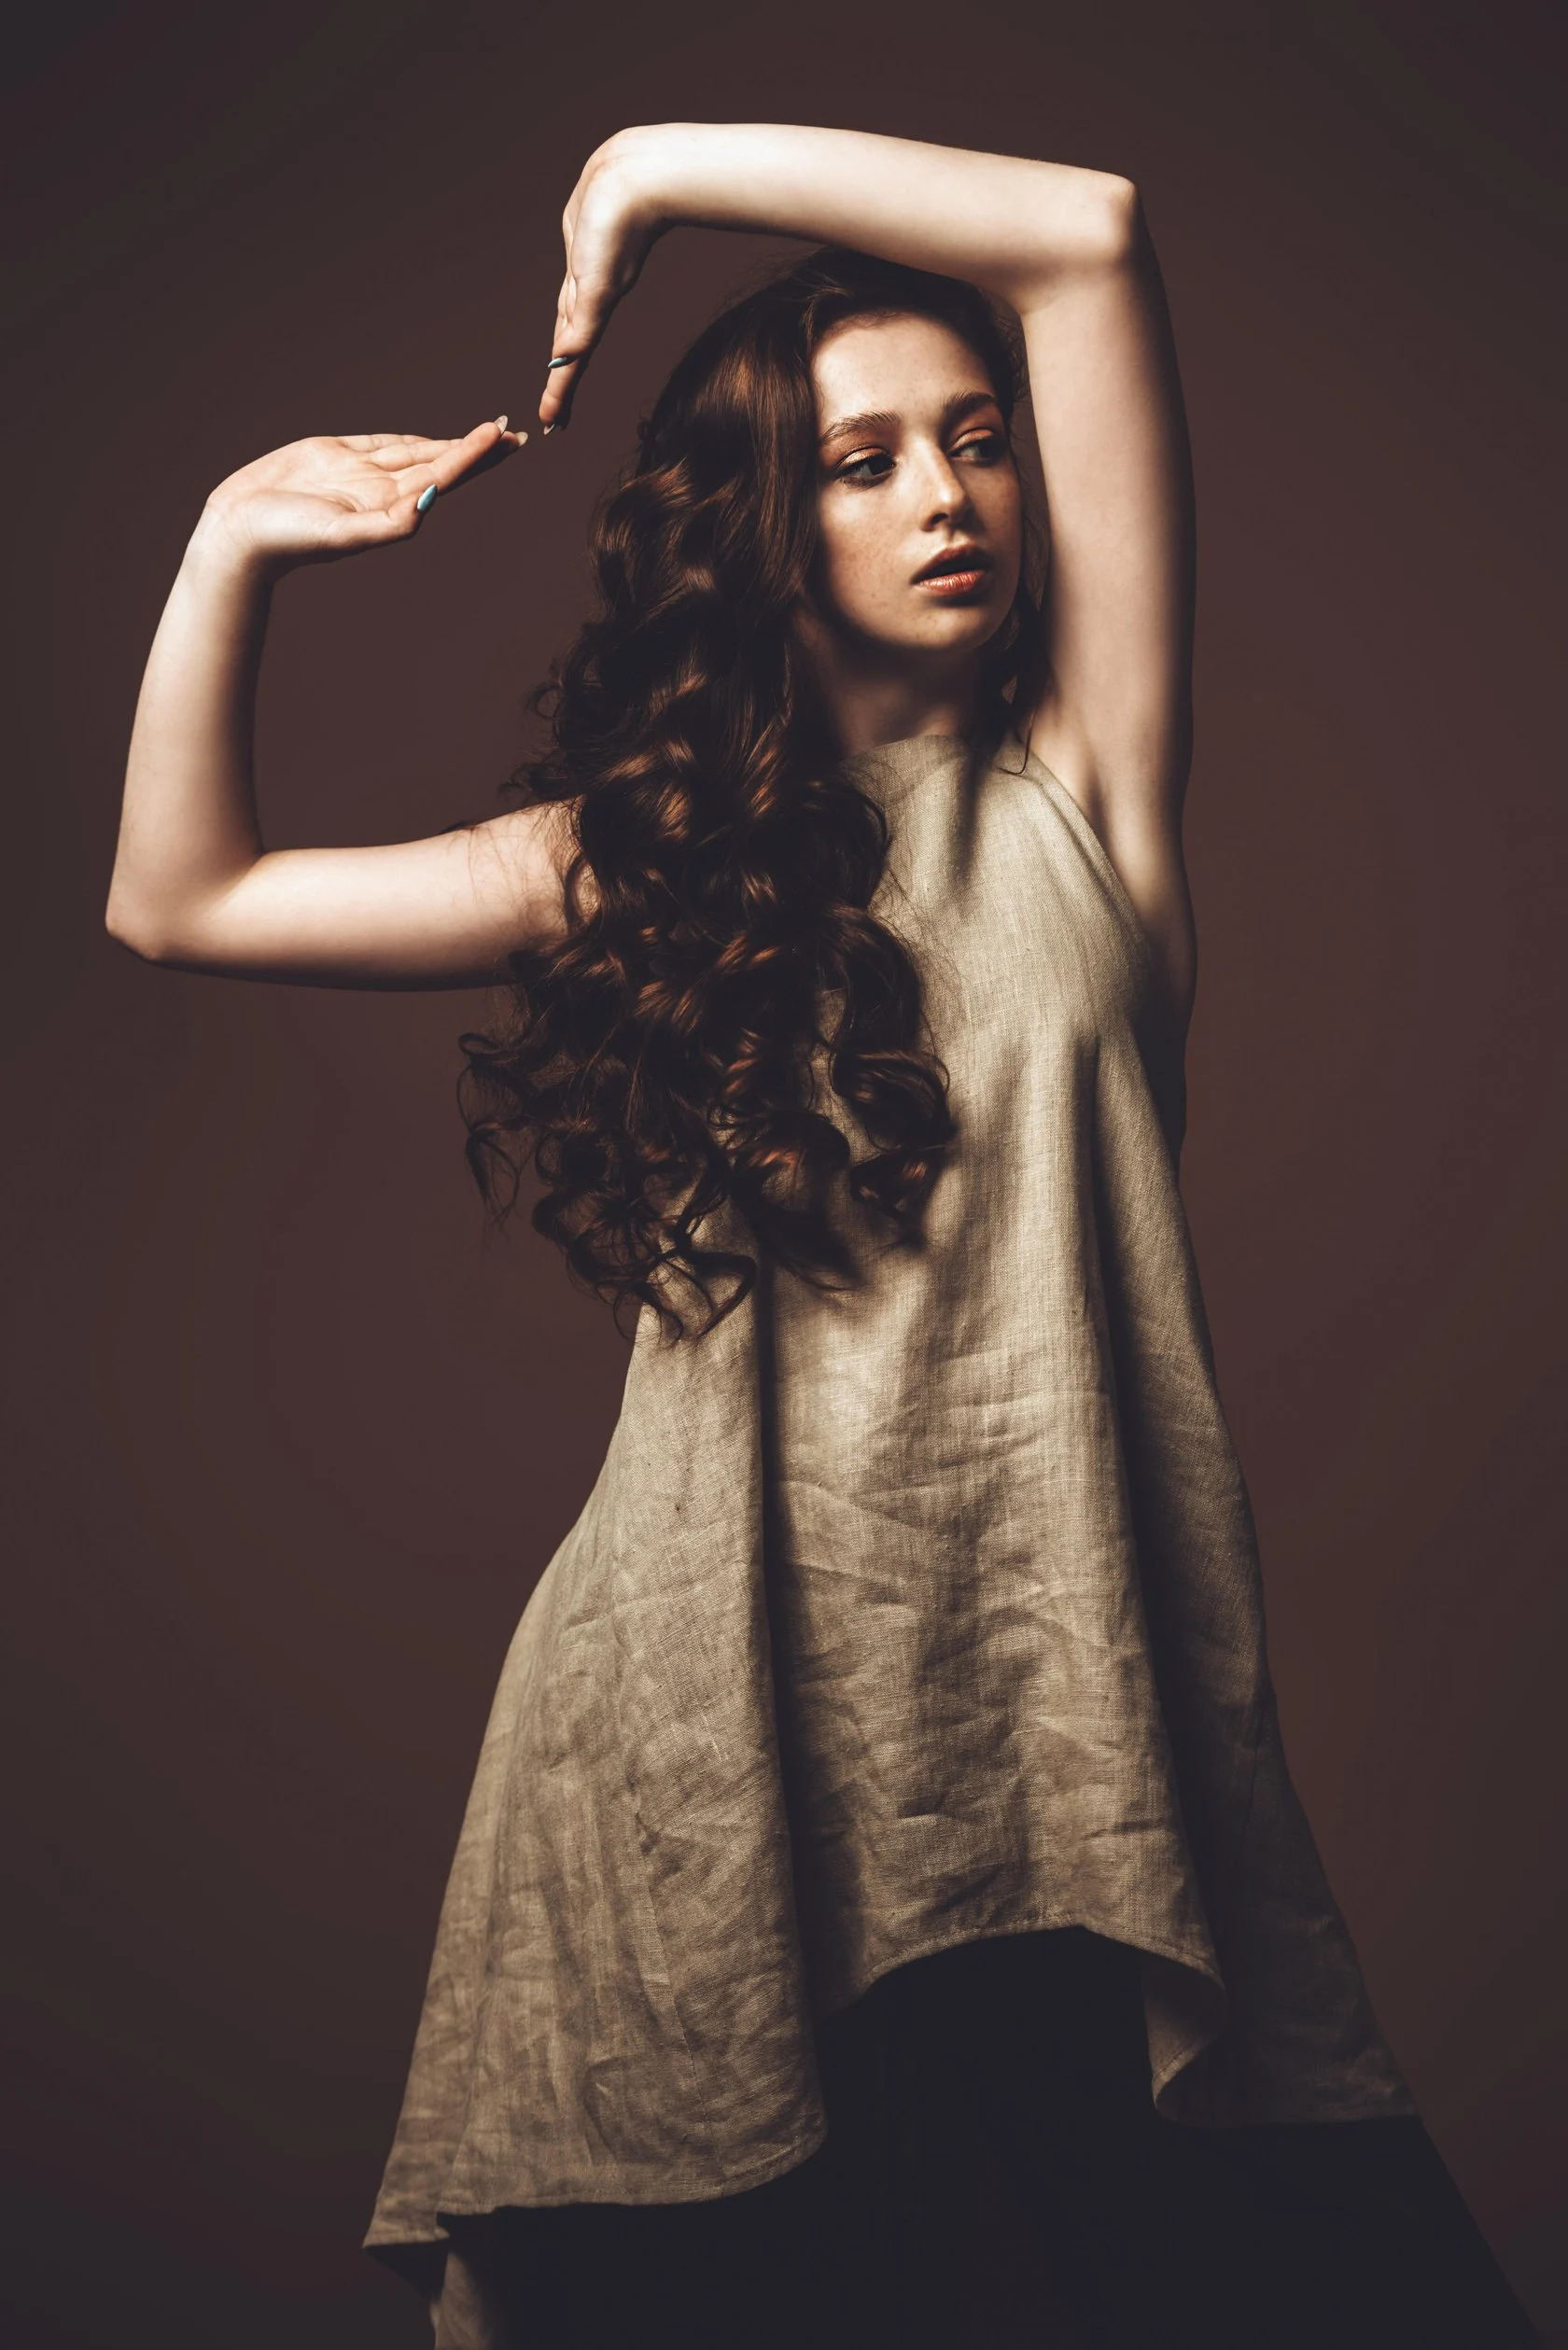

In [11]:
img = load_image(POSE_REF_PATH) 
img

In [13]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Install configs and checkpoints
det_config='../pose_exp/yolox_l_8xb8-300e_coco.py'
det_ckpt='https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_l_8x8_300e_coco/yolox_l_8x8_300e_coco_20211126_140236-d3bd2b23.pth'
pose_config='../pose_exp/dwpose-l_384x288.py'
pose_ckpt='https://huggingface.co/wanghaofan/dw-ll_ucoco_384/resolve/main/dw-ll_ucoco_384.pth'

from controlnet_aux import DWposeDetector

# dwpose = DWposeDetector(det_config=det_config, det_ckpt=det_ckpt, pose_config=pose_config, pose_ckpt=pose_ckpt, device=device)
dwpose = DWposeDetector(det_config=det_config, det_ckpt=det_ckpt, pose_config=pose_config, pose_ckpt=pose_ckpt)

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_l_8x8_300e_coco/yolox_l_8x8_300e_coco_20211126_140236-d3bd2b23.pth
Loads checkpoint by http backend from path: https://huggingface.co/wanghaofan/dw-ll_ucoco_384/resolve/main/dw-ll_ucoco_384.pth


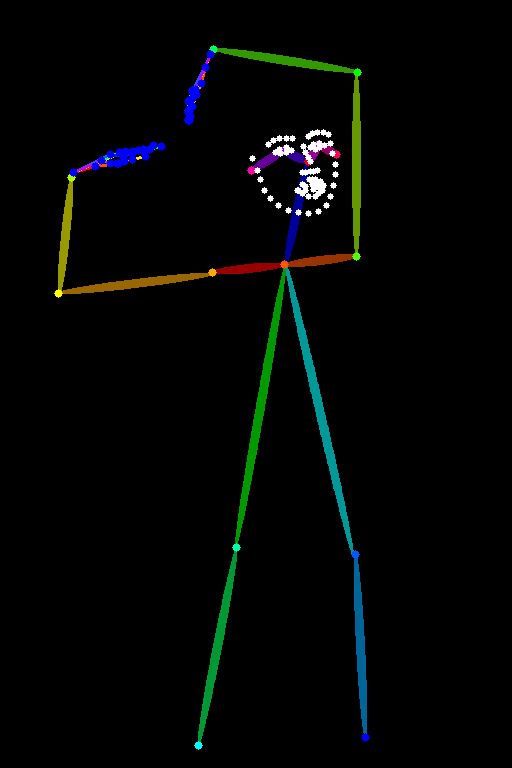

In [16]:
pose_2 = dwpose(img)
pose_2

In [36]:
CONTROL_MODEL="lllyasviel/control_v11p_sd15_openpose"
controlnet = ControlNetModel.from_pretrained(
    CONTROL_MODEL, torch_dtype=torch.float16
)

model_id = SD_BASE
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    model_id,
    controlnet=controlnet,
    torch_dtype=torch.float16,
    safety_checker = None
).to("cuda")

# from diffusers import StableDiffusionPipeline
# pipe = StableDiffusionPipeline.from_pretrained(
#             model_id,
#             local_files_only=True,
# #             controlnet=controlnet,
#             torch_dtype=torch.float16, 
#             safety_checker = None
# ).to("cuda")

# pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
# pipe.enable_model_cpu_offload()

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/home/uday_bon/miniconda3/envs/sd-latest/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [37]:
prompt='Classic Hollywood glamour, girl in a stunning red evening gown, dazzling accessories, (captivating eyes, red lips, flawless skin), luxurious backdrop, velvet curtains, dramatic pose, interesting composition, spotlight illumination, rich shadows, shallow depth of field, sparkling bokeh, exquisite details, high-resolution, 35mm film, timeless elegance. portrait photography, 35mm film, natural blurry'
negative_prompt= "EasyNegative, ng_deepnegative_v1_75t, badhandv4, (worst quality:2), (low quality:2), (normal quality:2), lowres, watermark, monochrome, paintings, sketches, text, jpeg artifacts"

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [', natural blurry']


  0%|          | 0/30 [00:00<?, ?it/s]

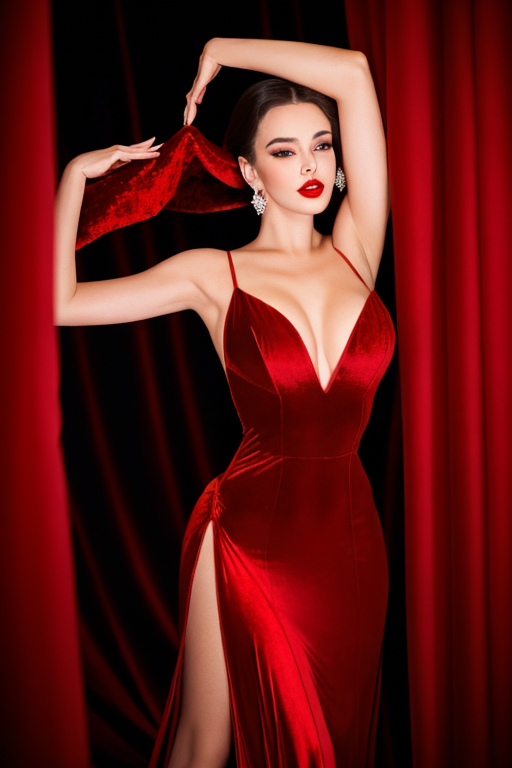

In [51]:
with autocast("cuda"):
    generator = torch.manual_seed(2555)
    image = pipe(prompt, negative_prompt=negative_prompt, num_inference_steps=30, generator=generator, image=pose_2).images[0]
#     image = pipe(prompt, negative_prompt=negative_prompt, num_inference_steps=40, generator=generator).images[0]
image

## Use AfterDetailer

In [39]:
from asdff import AdPipeline, AdCnPipeline

pipe_ad = AdCnPipeline.from_pretrained(
    model_id,
    controlnet=controlnet,
    torch_dtype=torch.float16,
    safety_checker = None
).to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'asdff.sd.AdCnPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [40]:
common = {"prompt": prompt, "negative_prompt": negative_prompt, "num_inference_steps": 30, "image":pose_2}


0: 640x448 1 face, 15.9ms
Speed: 18.1ms preprocess, 15.9ms inference, 14.3ms postprocess per image at shape (1, 3, 640, 448)
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_inpaint.StableDiffusionControlNetInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
Token indices sequence length is longer than the specified maximum sequence length for this model (80 > 77). Running this sequence through the model will result in indexing errors
The following part of your in

  0%|          | 0/12 [00:00<?, ?it/s]

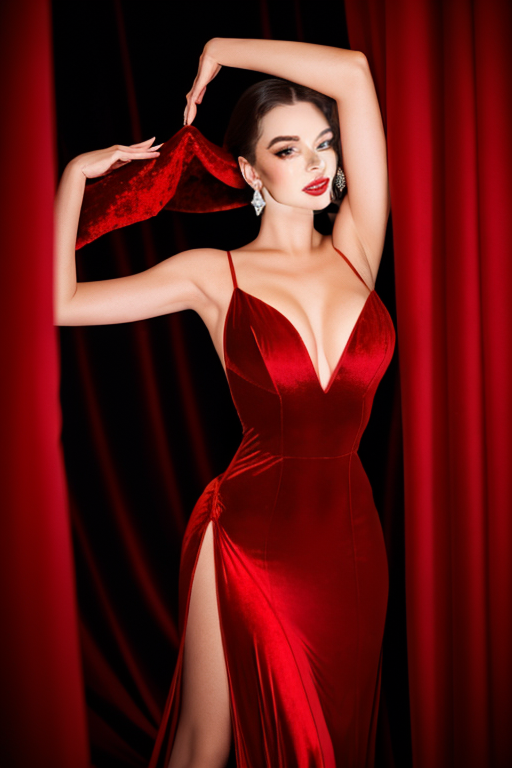

In [41]:
result= pipe_ad(common=common, images=[image])
result[0][0]

In [30]:
image =result[0]


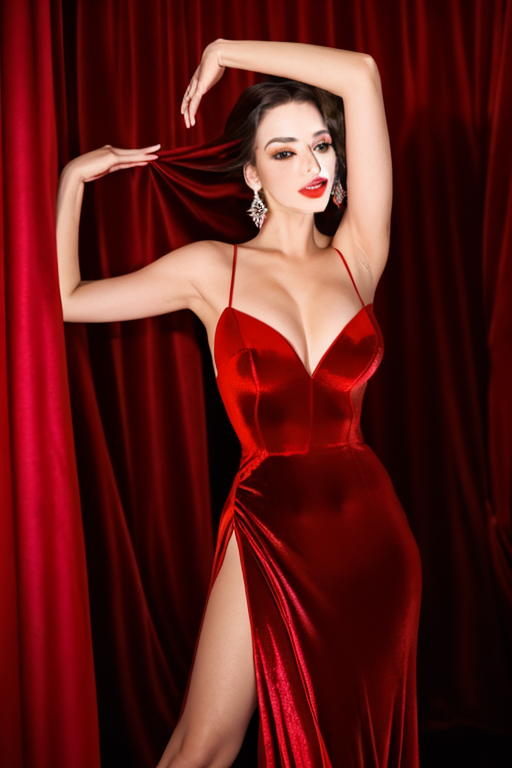

In [33]:
image[0]

In [43]:
from asdff import AdPipeline
pipe_ad = AdPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    safety_checker = None
).to("cuda")

pipe_ad.scheduler = DPMSolverMultistepScheduler.from_config(pipe_ad.scheduler.config)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'asdff.sd.AdPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [', natural blurry']


  0%|          | 0/30 [00:00<?, ?it/s]


0: 640x640 1 face, 9.2ms
Speed: 2.5ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [', natural blurry']


  0%|          | 0/12 [00:00<?, ?it/s]

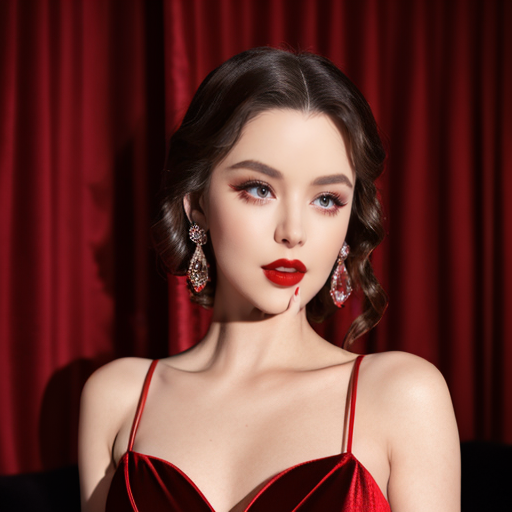

In [53]:
common = {"prompt": prompt, "negative_prompt": negative_prompt, "num_inference_steps": 30}
result= pipe_ad(common=common)
result[0][0]


0: 640x448 1 face, 9.8ms
Speed: 2.0ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [', natural blurry']


  0%|          | 0/12 [00:00<?, ?it/s]

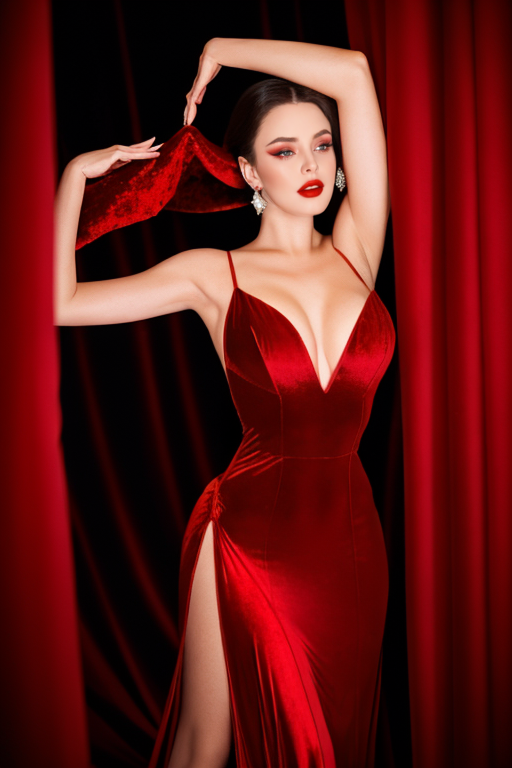

In [54]:
result= pipe_ad(common=common, images=[image])
result[0][0]


0: 640x448 1 face, 11.9ms
Speed: 2.6ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


  0%|          | 0/12 [00:00<?, ?it/s]

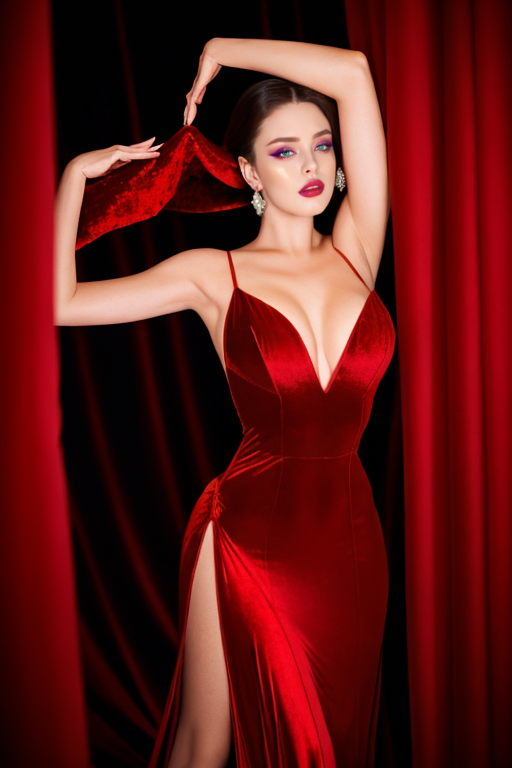

In [55]:
common = {"prompt": 'green eyes, purple lipstick,  beautiful face', "negative_prompt": negative_prompt, "num_inference_steps": 30}
result= pipe_ad(common=common, images=[result[0][0]])
result[0][0]